In [1]:
import os
from glob import glob
import numpy as np
import h5py
import matplotlib.pyplot as plt
plt.style.use('figure.mplstyle')

from function.data2p import get_data_bis
import function.tuning_function as tf

In [2]:
folder = r'D:\LW_Alldata\SI_Transient'
alldata = {'Enriched': glob(os.path.join(folder,'Enriched*.hdf5')),
           'Dissimilar': glob(os.path.join(folder,'Distinct*.hdf5')),
           'Similar': glob(os.path.join(folder,'Similar*.hdf5'))}

datapath = alldata['Enriched'][2]
day = 1  # Recording days, None for all days
min_rate = 1/60  # Minimum transient rate for active cells
pval_thr = 0.05  # Threshold for significant spatial information
ybin = 80  # Number of spatial bins
ysigma = 1  # Size of the Gaussian filter (in number of spatial bin) for smoothing the tuning curves

In [3]:
## Load all cells first
data, cells, days, ctx, selected_cells = get_data_bis(datapath, day=day, min_rate=min_rate, verbose=True)

with h5py.File(datapath, 'r') as f:
    yrange = f['params/yrange'][()]  # Dataset dependent
    
print('Recording days:', days)
print('Context fam/nov:', ctx)

------------------------------------
Total cells: 91
Active cells: 75
Proportion of active cells 82.42 %
Active in both 38.46 %
Active exclusively in Fam 20.88 %
Active exclusively in Nov 23.08 %
------------------------------------
Recording days: [1 1 1 1]
Context fam/nov: [0 1 0 1]


In [4]:
# %% Spatial tuning
tuning = tf.compute_tuning(data, yrange=yrange, ybin=ybin, ysigma=ysigma,
                           spike=False, transient=False)

In [5]:
print(selected_cells)

[ 1  2  3  4  5  7 10 11 12 13 14 15 16 17 18 22 23 24 25 26 27 29 30 31
 32 33 34 35 36 37 39 40 41 43 44 45 46 47 48 49 50 53 54 55 56 57 58 59
 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 77 80 81 82 83 84 85 86
 87 89 90]


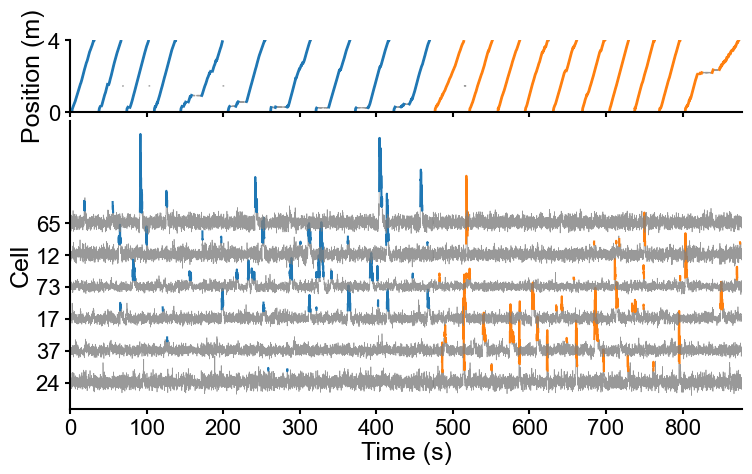

In [6]:
cellid = [np.where(selected_cells==i)[0].item() for i in [65,12,73,17,37,24]]  # cellid: indices in active subset of cells [70,12,78,19,41,28]
trialid = [range(0,10),range(0,10),[],[]]
colors = ['C0','C1']
fps = data['fps']
t0 = 0  # Time offset

fig, axs = plt.subplots(2,1, sharex=True, figsize=(7.8,4.8),
                        gridspec_kw={'height_ratios':[1,4]})

for k in range(len(trialid)):
    c = ctx[k]  # Fam/Nov
    if len(trialid[k]) > 0:
        nframes_ = np.hstack([0, np.cumsum(data['t'][k])])
        sub = np.hstack([np.arange(nframes_[r], nframes_[r+1]) for r in trialid[k]])
        t = t0 + np.arange(len(sub))/fps
        F = data['F'][k][:,sub]
        Tr = data['Tr'][k][:,sub]
        y = data['y'][k][sub]
        v = np.gradient(y)
        moving = data['moving'][k][sub]
        y[(y<yrange[0])|(y>=yrange[1])|(v<0)] = np.NaN
        y = (y - yrange[0])/(yrange[1] - yrange[0])*4
        y2 = y.copy()
        y2[~moving] = np.NaN
        axs[0].plot(t, y, lw=1, c='gray', alpha=0.8)
        axs[0].plot(t, y2, lw=2, c=colors[c])
        t0 += len(sub)/fps
        
        for i, ii in enumerate(cellid[::-1]):
            axs[1].plot(t, i+F[ii], lw=0.5, c='gray', alpha=0.8)      
            F2 = F[ii].copy()
            F2[~Tr[ii]] = np.NaN
            axs[1].plot(t, i+F2, lw=1.5, c=colors[c])

axs[0].set(yticks=[0,4], ylabel='Position (m)', ylim=[0,4], xlim=[0,t0])
axs[1].set(yticks=range(6), yticklabels=selected_cells[cellid][::-1],
           ylabel='Cell', xlabel='Time (s)')
fig.tight_layout()
fig.subplots_adjust(hspace=0.05)
# fig.savefig('Example traces enriched3.svg')

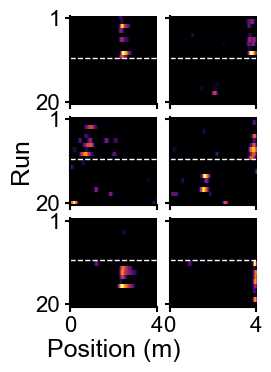

In [17]:
fig, axs = plt.subplots(3,2, figsize=(3,4), sharex=True, sharey=True)

for i, ii in enumerate(cellid):
    ax = axs.ravel()[i]
    Fy, level = [], []
    for k in range(len(trialid)):
        if len(trialid[k]) > 0:
            Fy.append(tuning[k][ii][:,trialid[k]].T)  # (ntrial, ybin)
            level.append(len(trialid[k]))
    Fy = np.vstack(Fy)
    ax.imshow(Fy, interpolation='none', cmap='inferno', extent=[0,Fy.shape[1],Fy.shape[0]+0.5,0.5])
    for l in np.cumsum(level)[:-1:]:
        ax.axhline(l, lw=1, ls='--', c='w')
    ax.set_aspect('auto')
    ax.set(xticks=[0,Fy.shape[1]], xticklabels=[0,4], yticks=[Fy.shape[0],1])
axs[1,0].set_ylabel('Run')
axs[2,0].set_xlabel('Position (m)')
fig.tight_layout()
fig.subplots_adjust(wspace=0.15, hspace=0.15)
fig.savefig('Example tuning enriched3.svg')